In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# HOPP Käppyrää

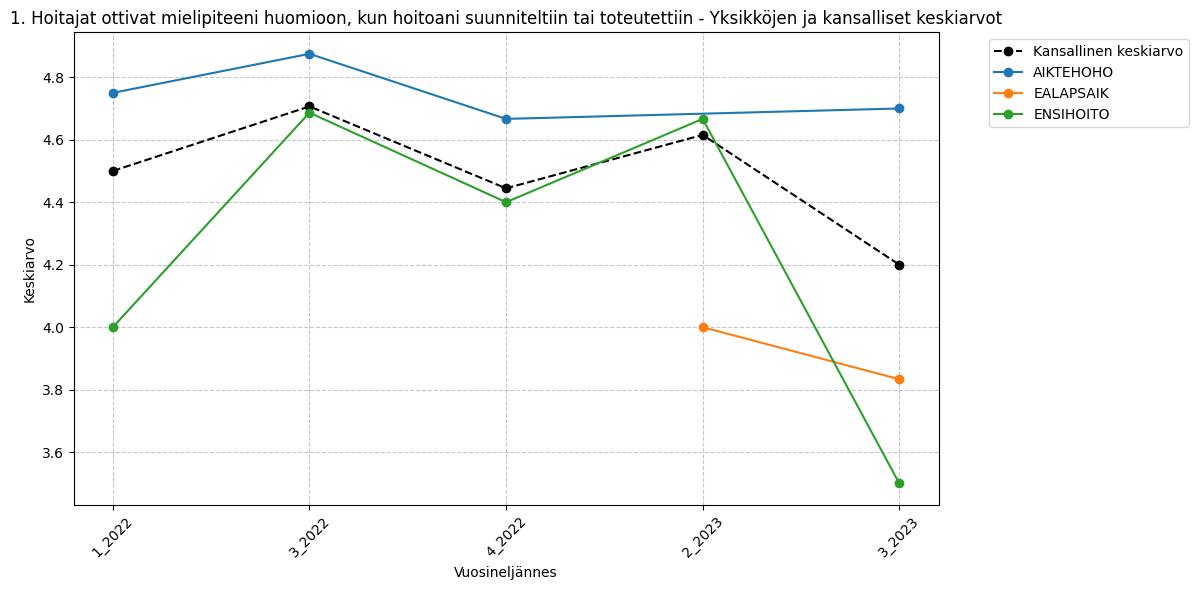

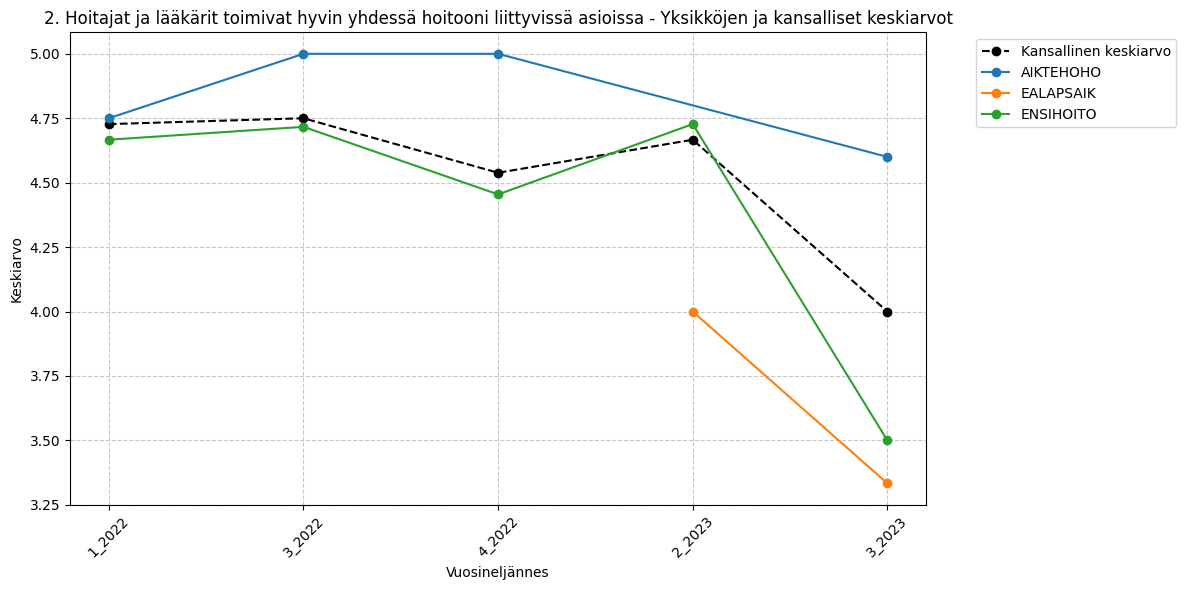

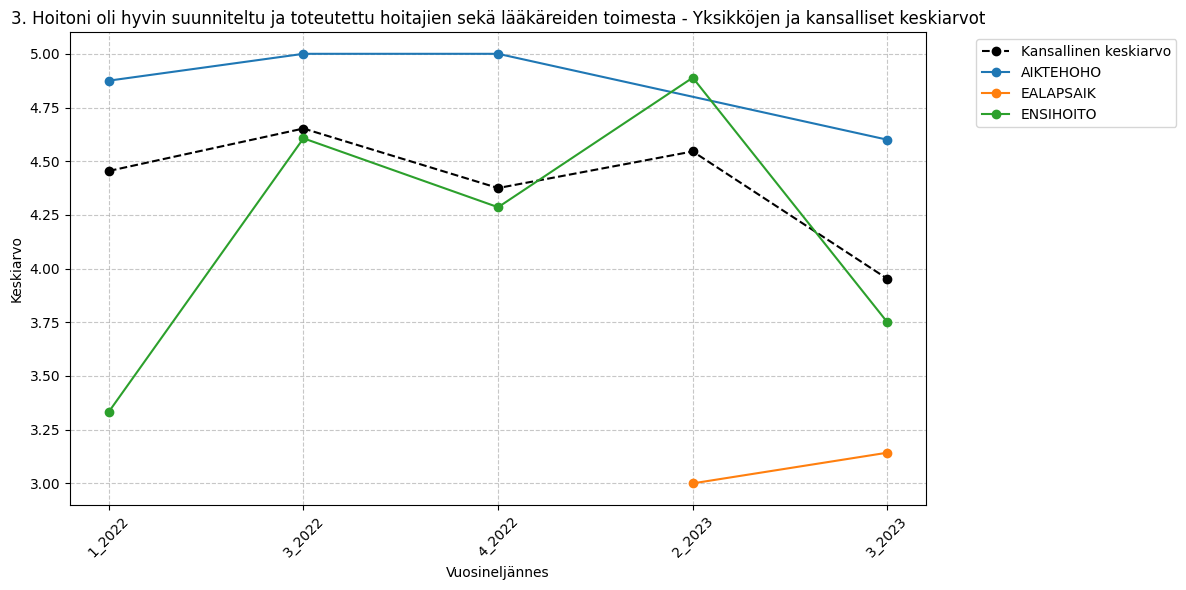

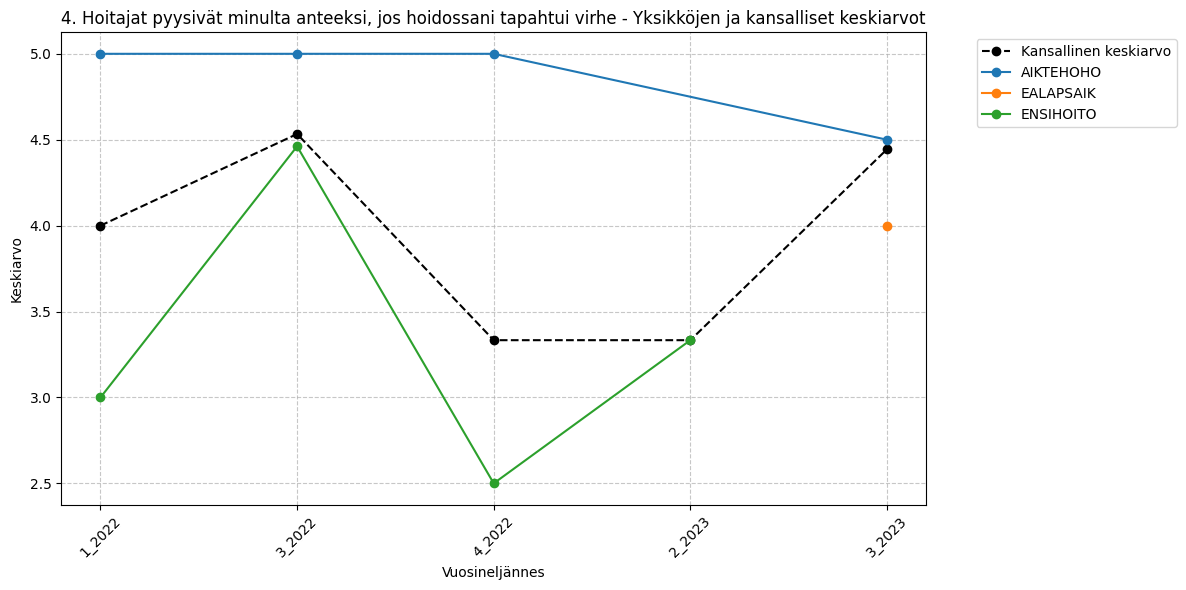

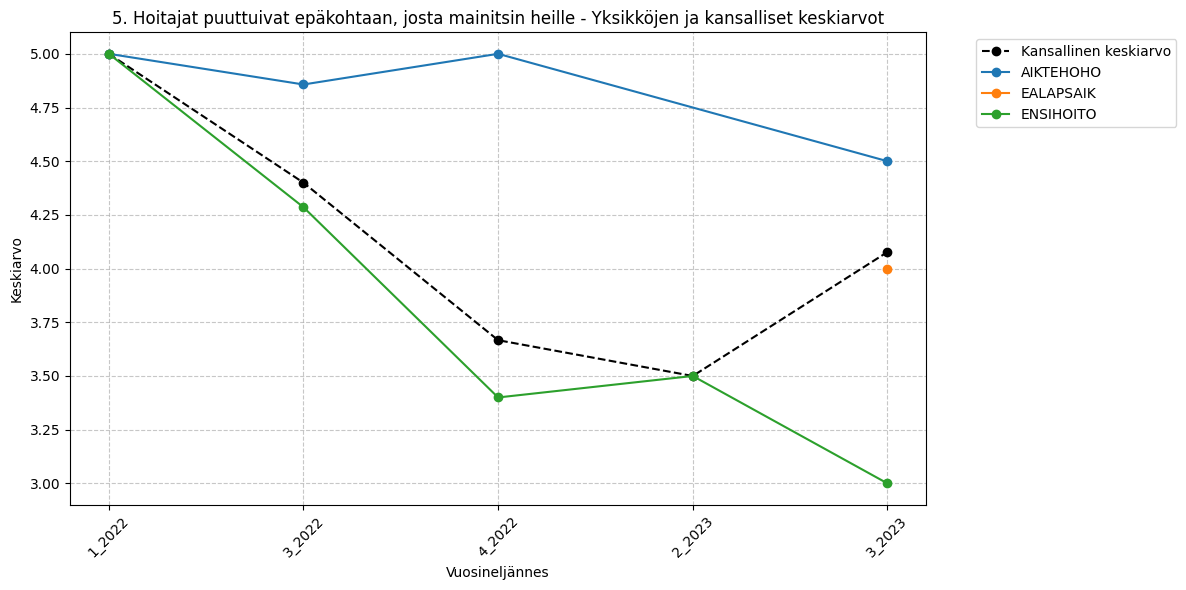

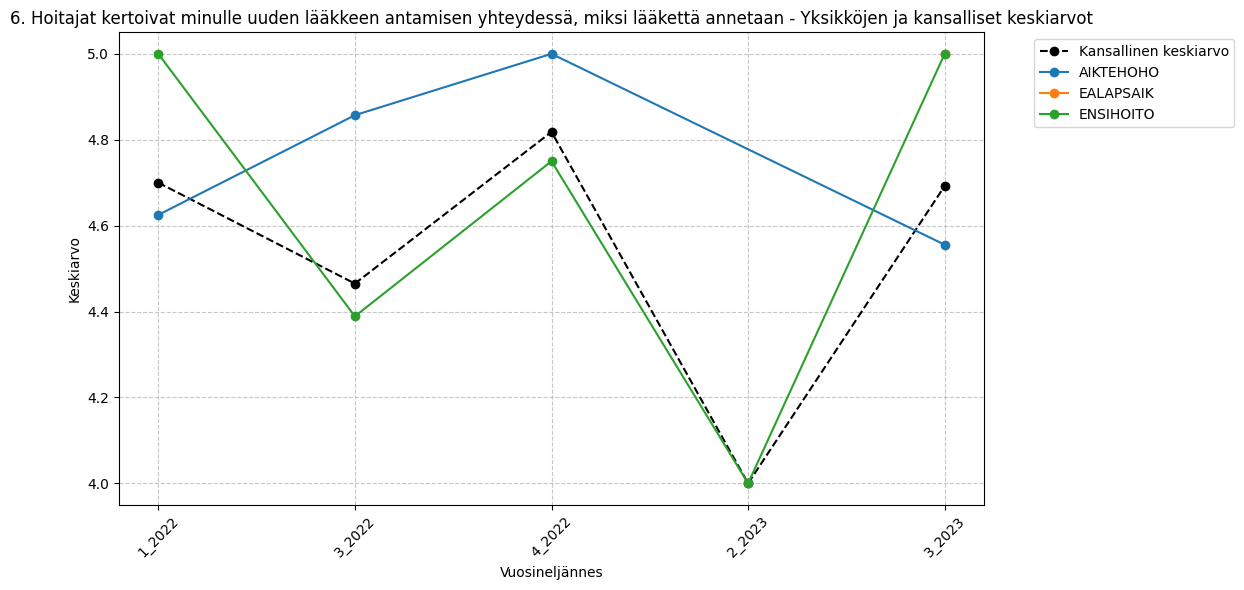

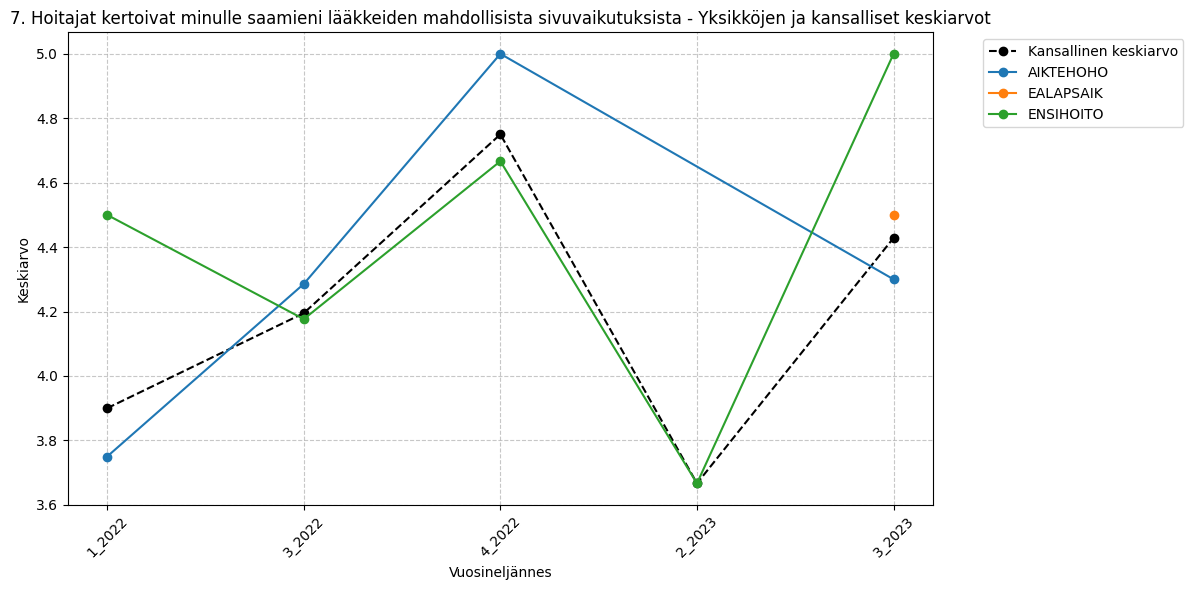

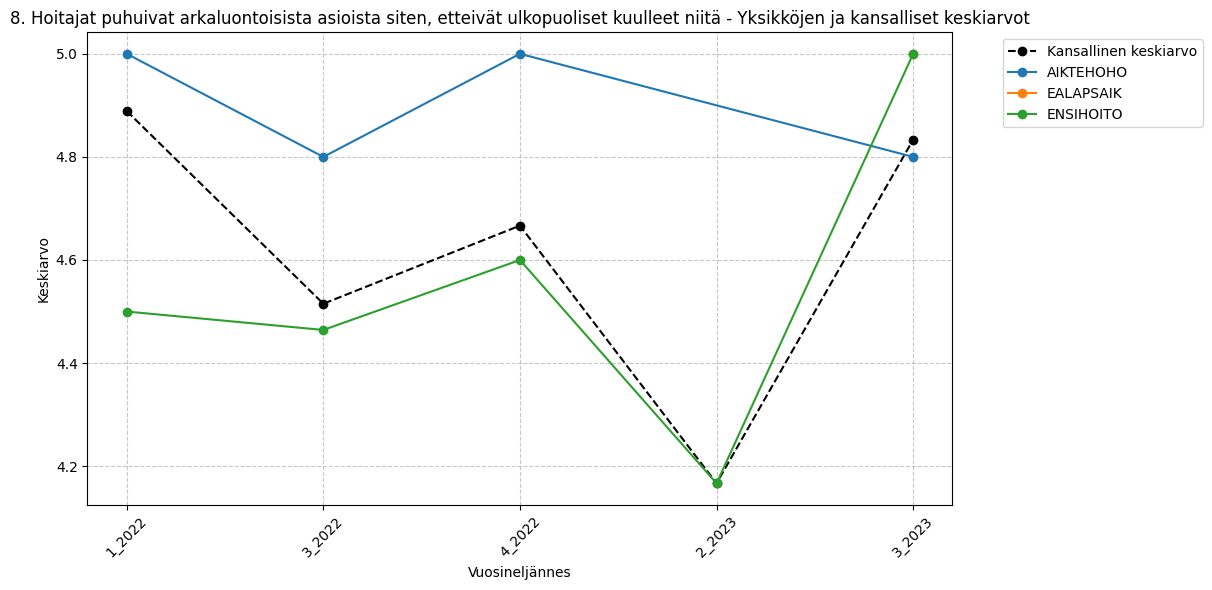

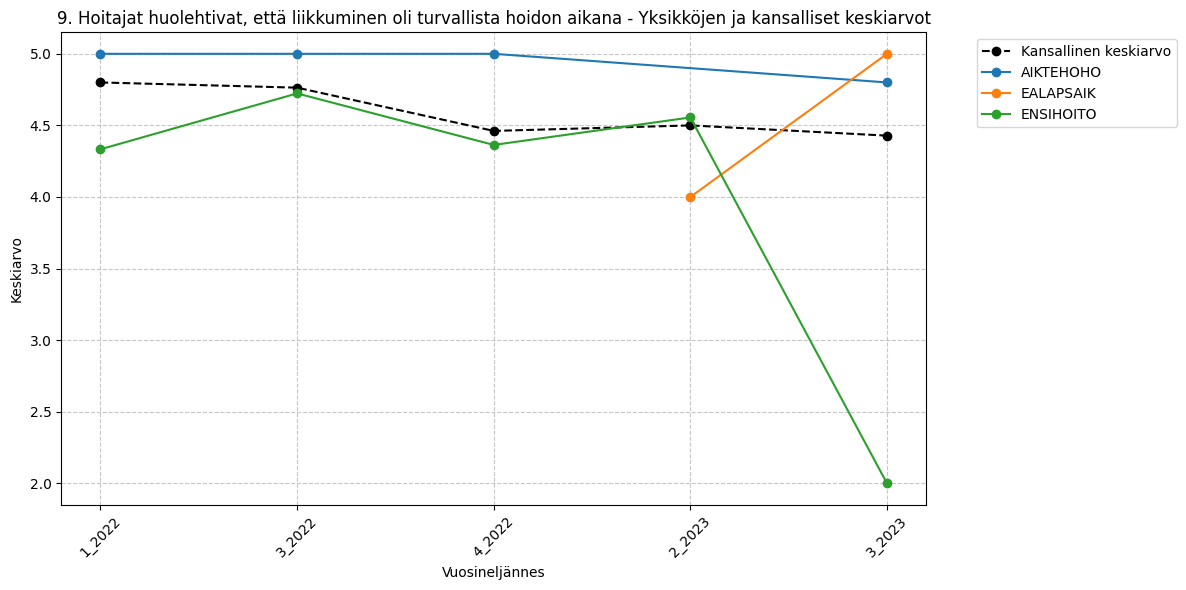

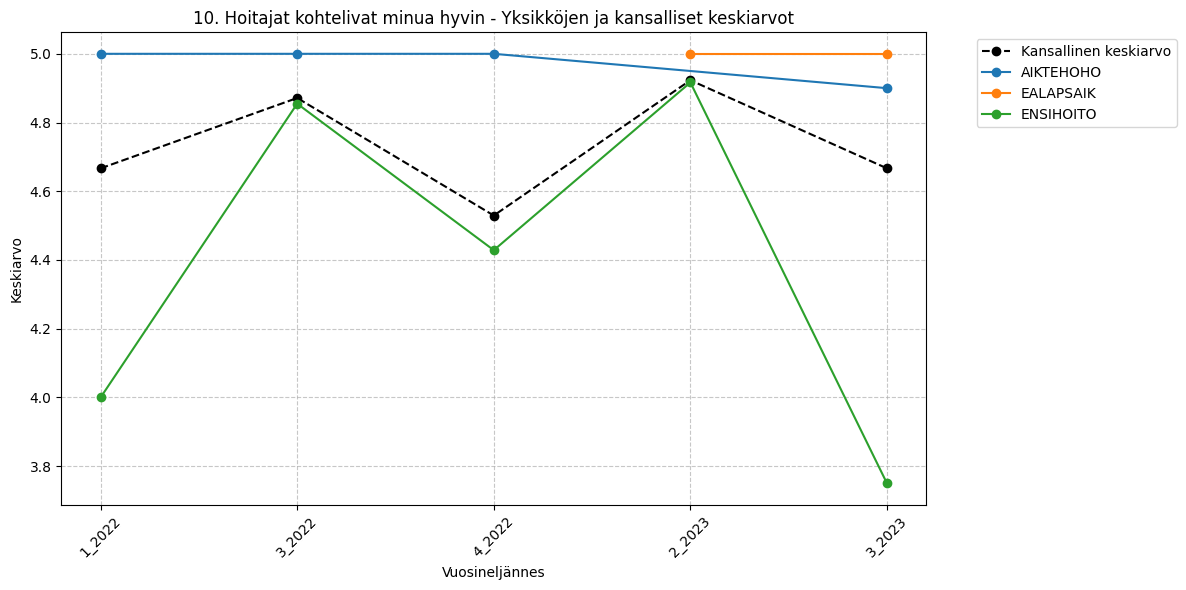

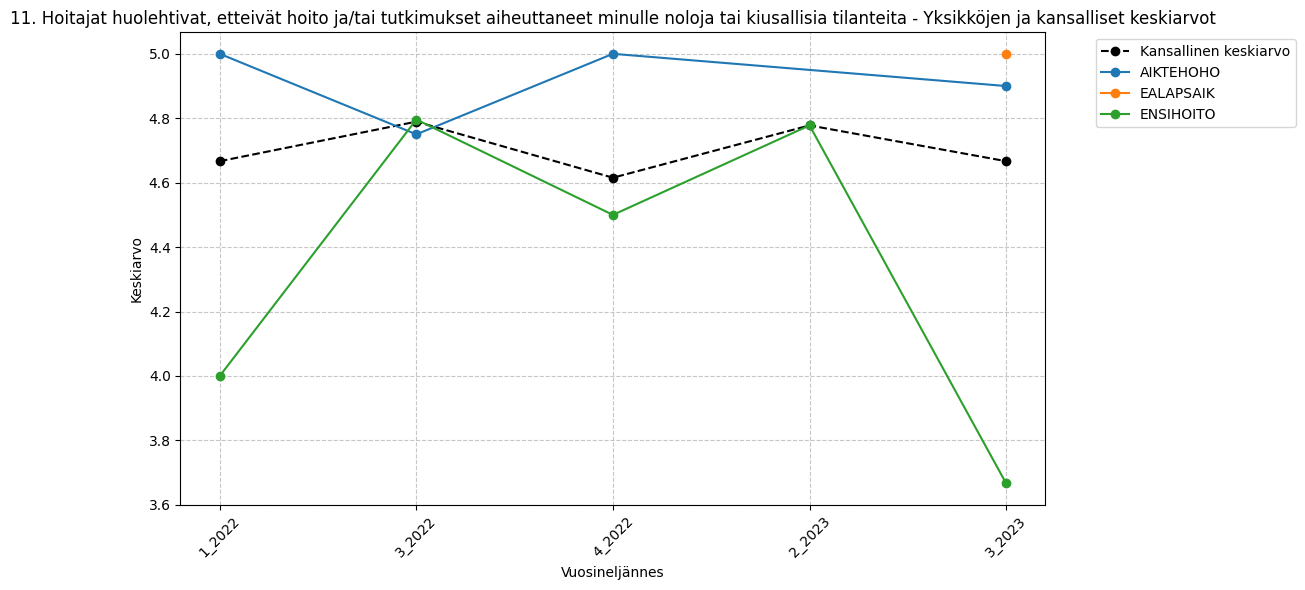

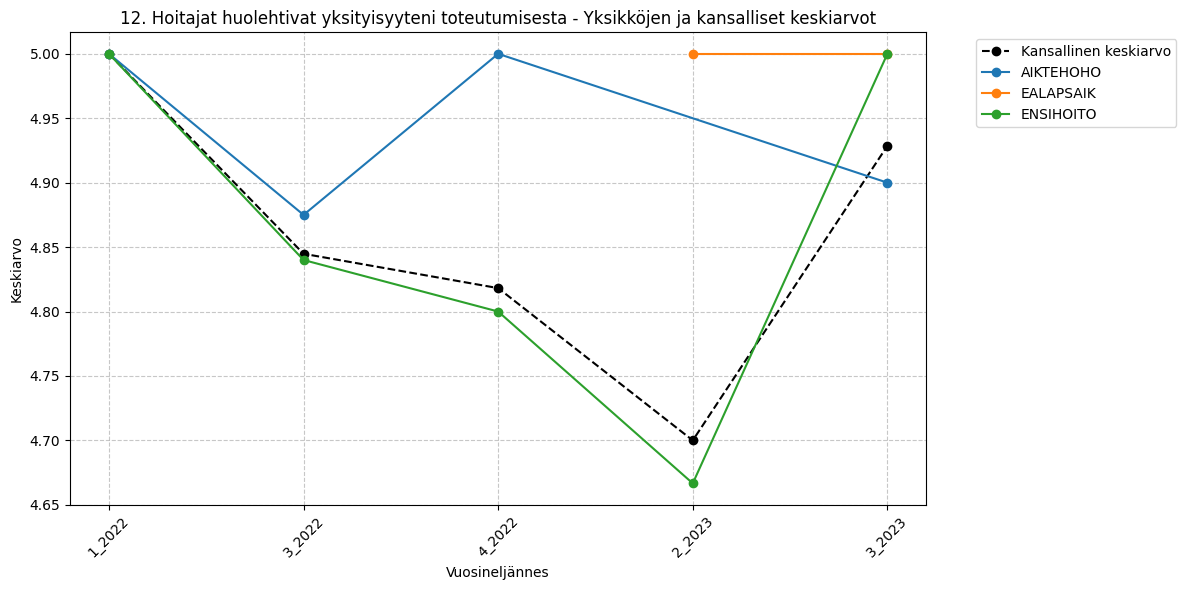

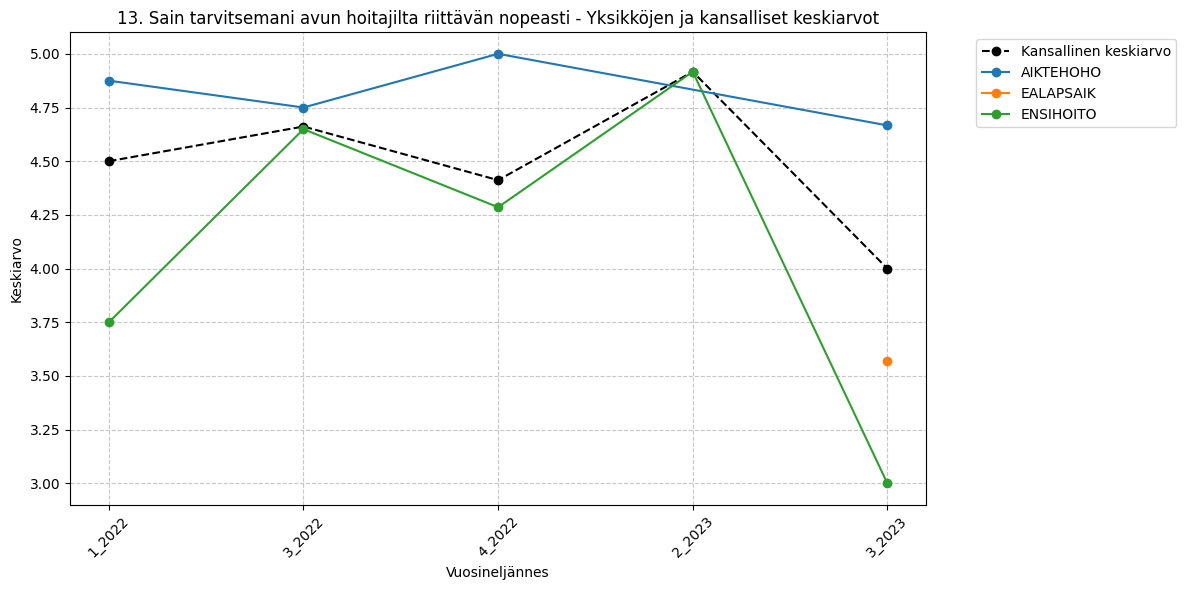

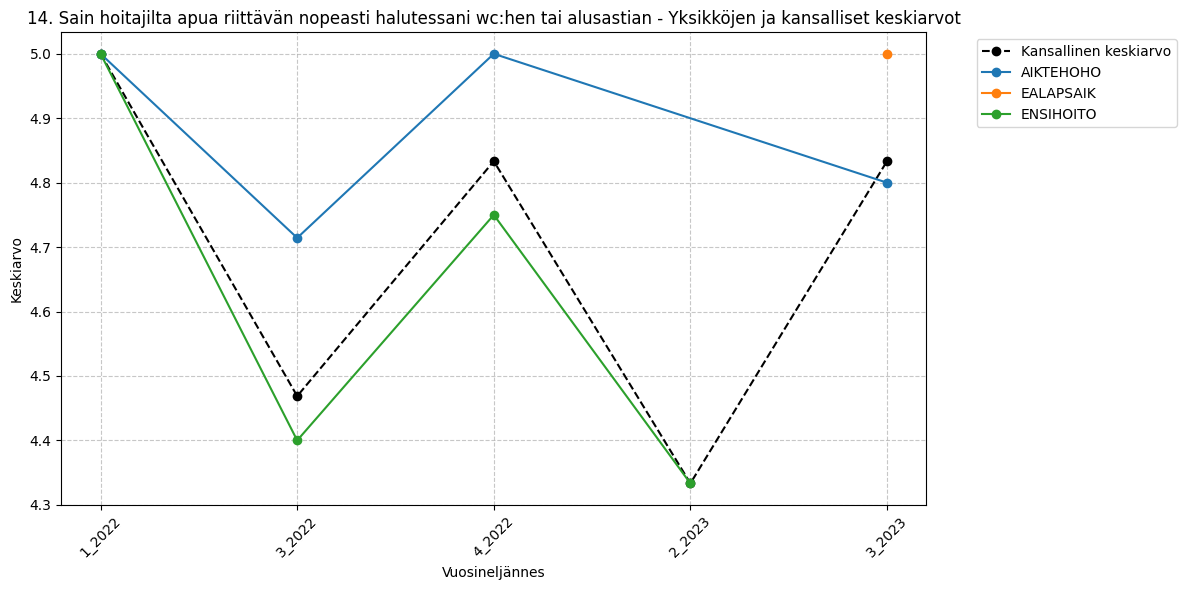

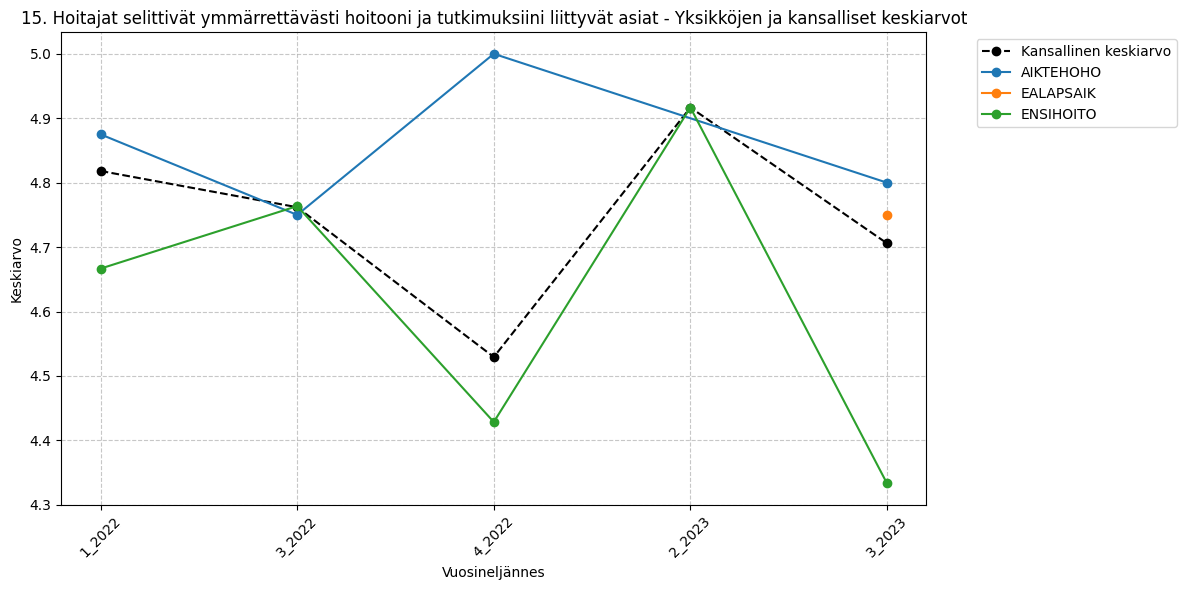

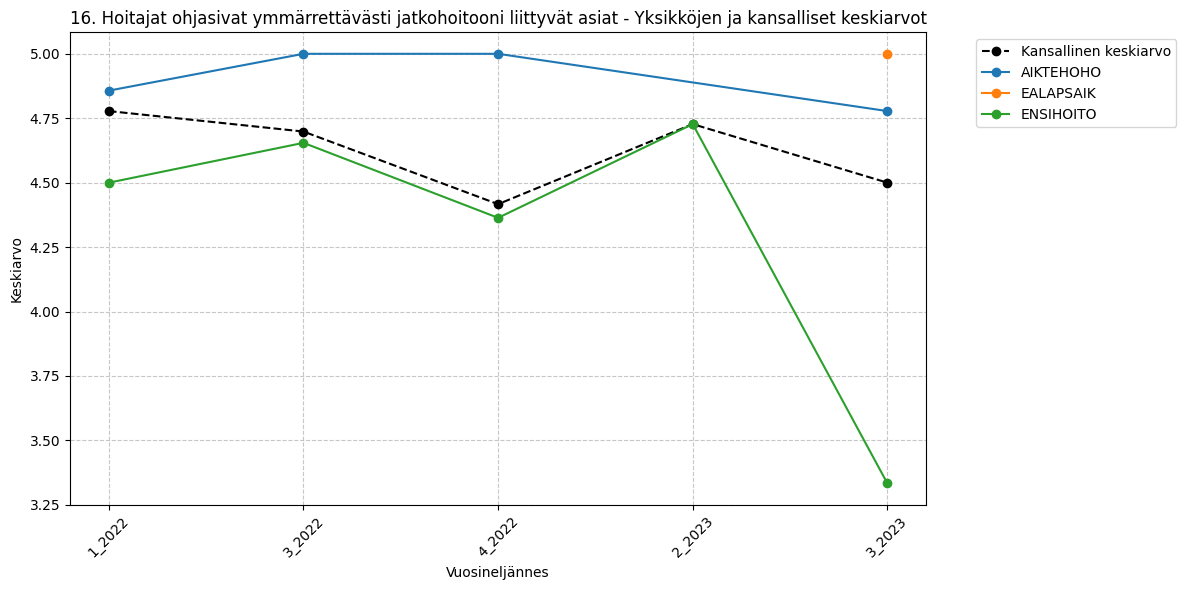

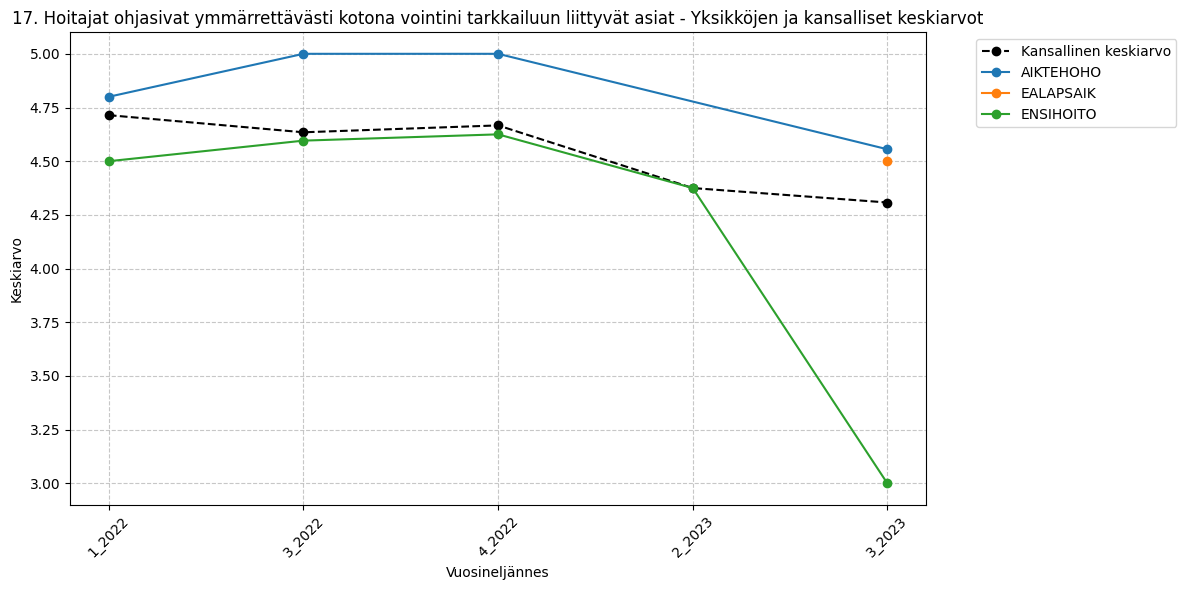

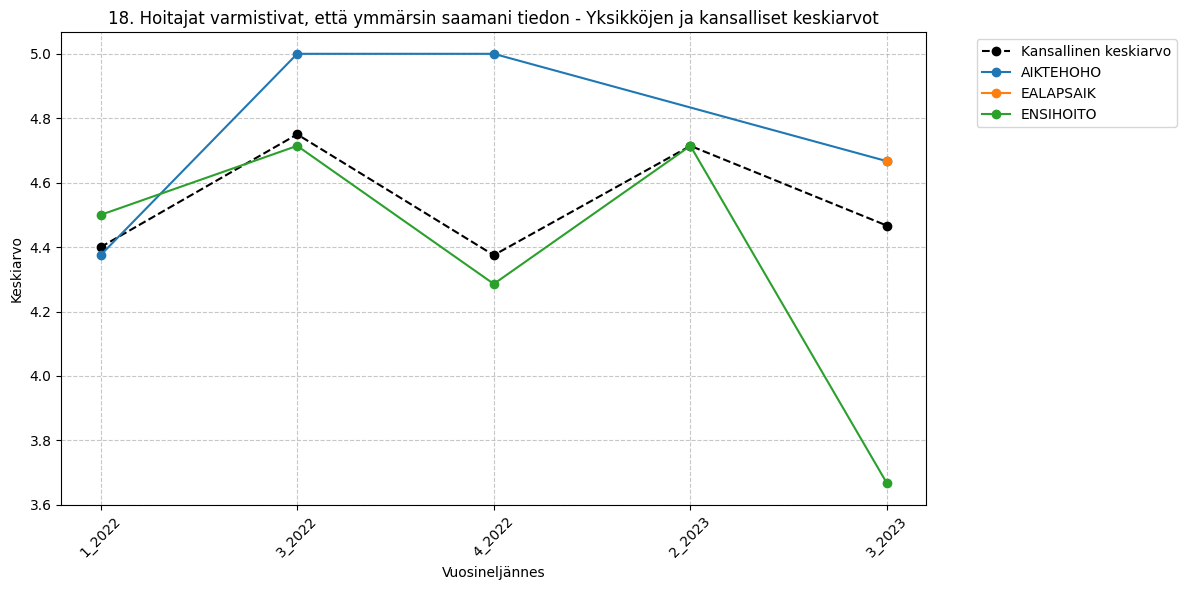

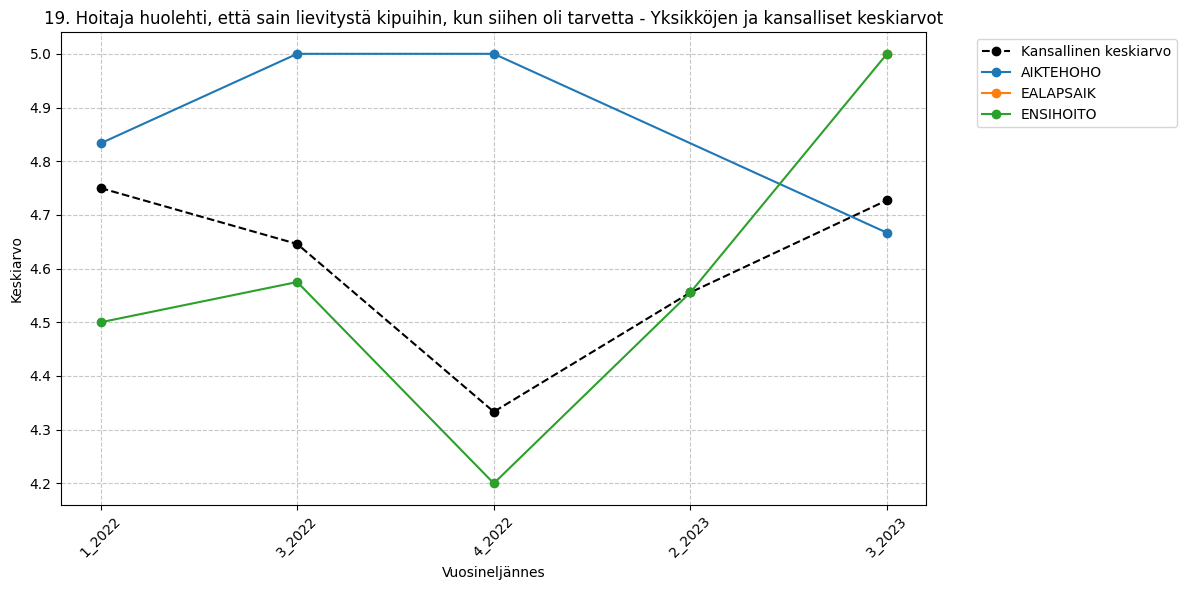

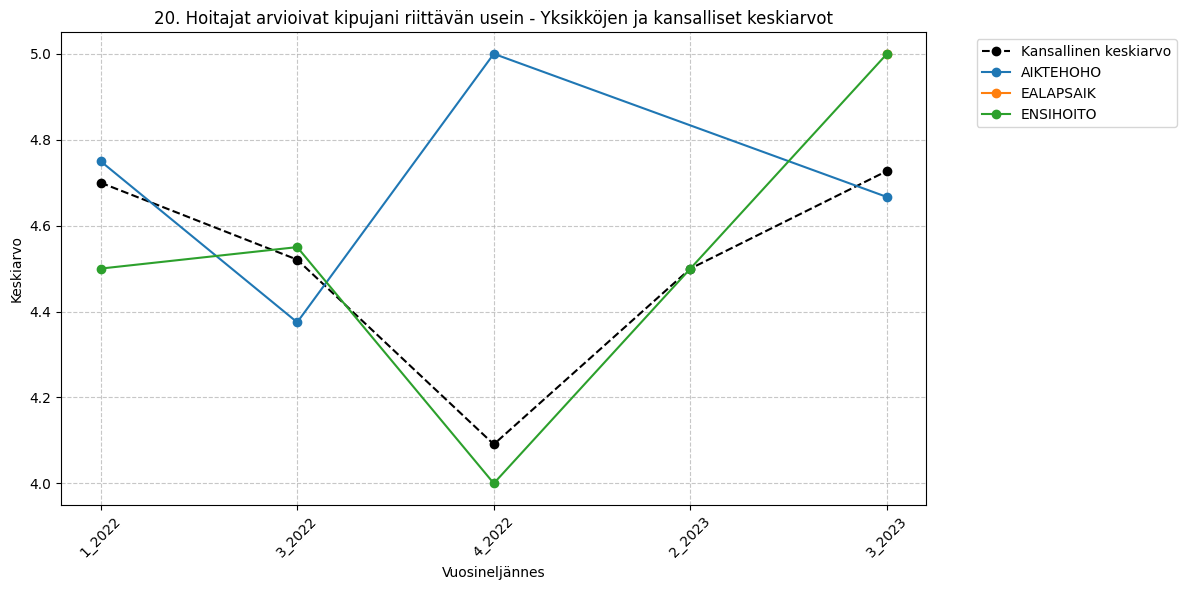

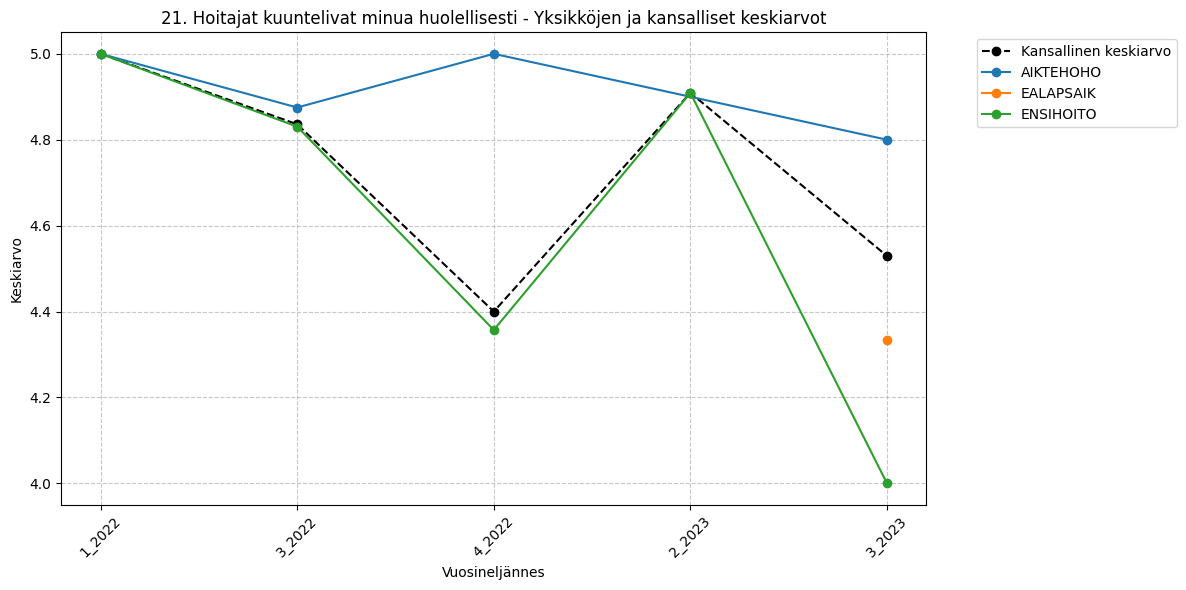

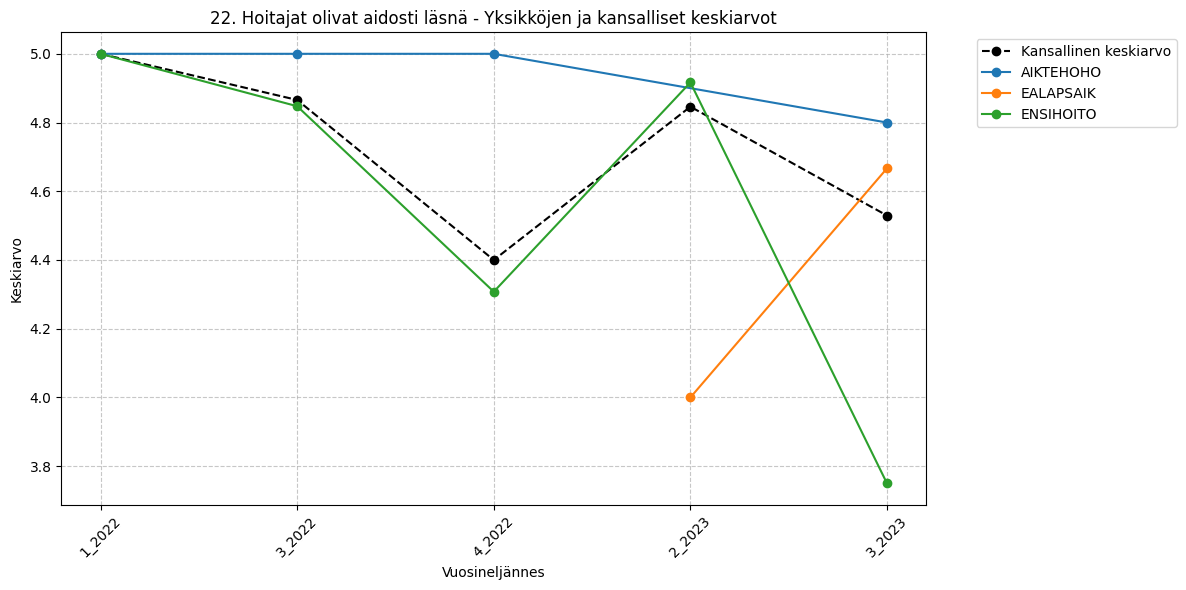

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Määritä polku kansioon, jossa tiedostot sijaitsevat
data_folder = "C:/Users/jonik/code/Projekti_2/project_sigma/data/HOPP"

# Tiedostojen polut
file_paths = [
    f"{data_folder}/117_HOpp-Q2_2023.xlsx",
    f"{data_folder}/117_HOpp-Q3_2023.xlsx",
    f"{data_folder}/HoPP_Q1_Kaks_Tiedonkeruulomake_kansallinen_2022.xlsx",
    f"{data_folder}/HoPP_Q3_KAKS_Tiedonkeruulomake_kansallinen_2022.xlsx",
    f"{data_folder}/HoPP_Q4_KAKS_Tiedonkeruulomake_kansallinen_2022.xlsx",
]

# Lataa ja yhdistä data
data_frames = []
for file in file_paths:
    df = pd.read_excel(file)
    data_frames.append(df)

data = pd.concat(data_frames, ignore_index=True)

# Määritä numeeriset sarakkeet (kysymykset 1-22)
numeric_columns = [col for col in data.columns if col.startswith(tuple([f"{i}." for i in range(1, 23)]))]

# Suodata vain halutut yksiköt
selected_units = ["AIKTEHOHO", "EALAPSAIK", "ENSIHOITO"]
data = data[data["YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä"].isin(selected_units)]

# Korvaa 'E' arvot NaN:lla ja muunna numerot
data[numeric_columns] = data[numeric_columns].replace('E', pd.NA)
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Ryhmittele data yksikön ja vuosineljänneksen mukaan
unit_avg = data.groupby([
    'YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä',
    'KVARTAALI JA VUOSI\n(ESIM. 1_2020)'
])[numeric_columns].mean()

# Laske kansalliset keskiarvot
national_avg = data.groupby('KVARTAALI JA VUOSI\n(ESIM. 1_2020)')[numeric_columns].mean()

# Määritellään järjestysfunktio
def sort_quarters(df):
    def quarter_to_float(q):
        quarter, year = q.split('_')
        return float(year) + (float(quarter) - 1) / 4

    if isinstance(df.index, pd.MultiIndex):
        quarter_level = 1
        sorted_quarters = sorted(df.index.levels[quarter_level], key=quarter_to_float)
        return df.reindex(level=quarter_level, labels=sorted_quarters)
    else:
        return df.reindex(sorted(df.index, key=quarter_to_float))

# Järjestä keskiarvot
national_avg = sort_quarters(national_avg)
unit_avg = sort_quarters(unit_avg)

# Visualisoi tulokset (vain kerran)
for question in numeric_columns:
    plt.figure(figsize=(12, 6))
    
    # Kansalliset keskiarvot
    plt.plot(
        national_avg.index,
        national_avg[question],
        label="Kansallinen keskiarvo",
        color="black",
        linestyle="--",
        marker='o'
    )
    
    # Yksikköjen keskiarvot
    for unit in selected_units:
        if unit in unit_avg.index.get_level_values(0):
            unit_data = unit_avg.loc[unit]
            plt.plot(
                unit_data.index,
                unit_data[question],
                label=unit,
                marker='o'
            )
    
    plt.title(f"{question} - Yksikköjen ja kansalliset keskiarvot")
    plt.xlabel("Vuosineljännes")
    plt.ylabel("Keskiarvo")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [10]:
import ipywidgets as widgets
from ipywidgets import interact


def create_hopp_table(data, unit, quarter):
    # Suodata data yksikön mukaan
    unit_data = data[data["YKSIKKÖKOODI\nKs. Luokitteluohje Yksikkökoodit-välilehdeltä"] == unit]
    quarter_data = unit_data[unit_data["KVARTAALI JA VUOSI\n(ESIM. 1_2020)"] == quarter]
    
    # Laske kansallinen keskiarvo kyseiselle vuosineljännekselle
    national_data = data[data["KVARTAALI JA VUOSI\n(ESIM. 1_2020)"] == quarter]
    national_avg = national_data[numeric_columns].mean()
    
    # Luo yhteenvetotaulukko
    summary = pd.DataFrame({
        'Rivikotsikot': ['Aikuiset'] * len(numeric_columns),
        'Luokittelukoodi': [unit] * len(numeric_columns),
        'Vuosineljännes': [quarter] * len(numeric_columns),
        'Kysymys': numeric_columns,
        'Kyselyitä': quarter_data[numeric_columns].notna().sum(),
        'Vastauksia': quarter_data[numeric_columns].count(),
        'Keskiarvo': quarter_data[numeric_columns].mean().round(2),
        'Kansallinen keskiarvo': national_avg.round(2)
    })
    
    return summary

# Hae uniikit vuosineljännekset ja järjestä ne
quarters = sorted(data["KVARTAALI JA VUOSI\n(ESIM. 1_2020)"].unique())
units = ["AIKTEHOHO", "EALAPSAIK", "ENSIHOITO"]

# Luo interaktiivinen näkymä
def interactive_table(quarter, unit):
    summary = create_hopp_table(data, unit, quarter)
    
    # Muotoile taulukko
    styled_table = summary.style.set_properties(**{
        'font-size': '11pt',
        'font-family': 'Arial',
        'text-align': 'left',
        'padding': '5px'
    }).format({
        'Keskiarvo': '{:.2f}',
        'Kansallinen keskiarvo': '{:.2f}'
    })
    
    display(styled_table.hide_index())

# Luo pudotusvalikot
quarter_dropdown = widgets.Dropdown(
    options=quarters,
    description='Vuosineljännes:',
    style={'description_width': 'initial'}
)

unit_dropdown = widgets.Dropdown(
    options=units,
    description='Yksikkö:',
    style={'description_width': 'initial'}
)

# Näytä interaktiivinen taulukko
interact(interactive_table, quarter=quarter_dropdown, unit=unit_dropdown)

interactive(children=(Dropdown(description='Vuosineljännes:', options=('1_2022', '2_2023', '3_2022', '3_2023',…

<function __main__.interactive_table(quarter, unit)>